<h1> [Sleep-2-Learn] Part III - After Learning </h1>

# Sleep-2-Learn: Learning Analysis

In [33]:
## Check envirionment

try:
    from google.colab import drive
    
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Runtime has {:.1f} GB of available RAM\n'.format(ram_gb))

    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    LAB_PATH = '/content/drive/MyDrive/+Research/__SLEEP__Workspace/[Sleep-2-Learn]_dev/'
    print("NOTE: Running on Google CoLab")
except:
    print("NOTE: Not using Google CoLab")
    COLAB = False
    LAB_PATH = ''


NOTE: Not using Google CoLab


## Import Libraries

In [34]:
import os

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib import dates as plotdates
from matplotlib.figure import Figure
import seaborn as sns
from pandas.table.plotting import table 

from enum import Enum

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import pickle

import warnings


ModuleNotFoundError: No module named 'pandas.table'

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 20]


In [ ]:
#import sklearn
#print(sklearn.__version__)

# *** sklearn version >= 0.22 or higher can calculate multiclass AUC
# current version = 0.24.2

In [ ]:
# Get rid of warnings
warnings.simplefilter("ignore")


## Set Up

In [ ]:
class FeatureSource(Enum):
    tsfresh = 'tsfresh'
    Walch   = 'Walch'

In [ ]:
class Resampling(Enum):
    NoResamp    = None
    RandomUnder = RandomUnderSampler()
    RandomOver  = RandomOverSampler()
    Smote       = SMOTE()

In [ ]:
class ClassType(Enum):
    binary_sw    = '2-Class'    # 'Sleep-Wake'
    multi_3class = '3-Class'    # 'NREM-REM-Wake'
    multi_4class = '4-Class'    # 'Light-Deep-REM-Wake'
    multi_5class = '5-Class'    # 'N1-N2-N3-REM-Wake'


In [ ]:
class SleepClass(object):
    # Input class type or specify class in array of string format
    def get_sleep_class(class_type, types_array = []):
        if class_type == ClassType.binary_sw:
            return ['Sleep', 'Wake']
        elif class_type == ClassType.multi_3class:
            return ['NREM', 'REM', 'Wake']
        elif class_type == ClassType.multi_4class:
            return ['Deep', 'Light', 'REM', 'Wake']
        elif class_type == ClassType.multi_5class:
            return ['N3', 'N2', 'N1', 'REM', 'Wake']
        else:
            return types_array
        
    def get_metrics(class_type):
        classes = SleepClass.get_sleep_class(class_type)
        # Metrics for binary class
        if class_type == ClassType.binary_sw:
            # Base metrics for binary class
            metrics = ['Accuracy', 'AUC', 'Kappa', 'MCC']
            for each_class in classes:
                metrics.append(str(each_class)+'_Accuracy')  # Accuracy of each class (recall)
                metrics.append(str(each_class)+'_Pred')     # Predictive value of each class (precision)
            return metrics
        
        # Metrics for multi class
        else:
            # Base metrics for multi-class
            metrics = ['AUC', 'Kappa', 'MCC']
            for each_class in classes:
                metrics.append(str(each_class)+'_Accuracy') # Accuracy of each class
            return metrics
            

In [ ]:
class Metric(Enum):
    accuracy  = 'Accuracy'
    auc       = 'AUC'
    k         = 'Kappa'
    f1        = 'F1'
    mcc       = 'MCC'       # Matthews Correlation Coefﬁcient
    class_acc = '_Accuracy' # _Class Accuracy 


In [ ]:
class SearchParamsMethod(Enum):
    none    = 'No-Tuning'      
    custom  = 'Custom-Tuning'  # Custom GridSearchCV
    sklearn = 'Sklearn-Tuning' # GridSearchCV by SciKit-Learn

## Config

In [ ]:
# Setup default configuration
class Config(object):
    
    # --- Training set split
    train_split = 0.64   # Train:Test 18:10
    #train_split = 0.1    # Train:Test (for testing purpose)

    # --- Feature-set for testing
    epoch_test = 30
    
    


## Constants

In [ ]:
class Constants(object):
  
    EPOCH_SIZE = Config.epoch_test
    TEST_SPLIT = 1-Config.train_split

    MODEL_PATH      = LAB_PATH + 'trained_model/'
    FEATURE_SET     = LAB_PATH + '_features/feature-set/'
    
    #--- Features Path ----
    # Features extracted by tsfresh
    FEATURE_TS_TEST_EPOCH   = FEATURE_SET + 'tsfresh/epoch/'
    FEATURE_TS_EPOCH        = FEATURE_TS_TEST_EPOCH + '/size' + str(EPOCH_SIZE) + '/'

    DATA_PROCESSED_PATH     = FEATURE_TS_EPOCH + 'data-processing/'
    FEATURE_EXTRACTED_PATH  = FEATURE_TS_EPOCH + 'extracted-features/'
    FEATURE_TSFRESH_PATH    = FEATURE_TS_EPOCH + 'selected-features/'
    
    
    # Features extracted from Walch's method
    FEATURE_OUTPUT = LAB_PATH + 'outputs/features/'
    FEATURE_W_PATH = FEATURE_SET + 'walch/'
    
    #--- Model Performance Path ----
    EVAL_PATH   = LAB_PATH + '_performance/'
    PF_CV_PATH  = EVAL_PATH + 'test-case/'
    PF_EPOCH    = EVAL_PATH + 'epoch/'
    
    # +++ Experiment 1: compare features from Walch and tsfresh +++
    EXP1         = EVAL_PATH + 'exp_1/'
    PF_WF_PATH   = EXP1 + 'features_Walch/'
    PF_TS_PATH   = EXP1 + 'features_tsfresh/'
    EXP1_SUMMARY = EXP1 + 'experiment_summary/'
    
    


## Globol Variables

In [ ]:
class Var(object):
    ## --- Performance Analysis ---
    performance_score_dict = {} 
    cv_report = pd.DataFrame()
    


## Utilites

In [ ]:
class Utils(object):

    def dict_to_csv(dictionary, csv_filename):
        export_df = pd.DataFrame.from_dict(dictionary, orient='index')
        #export_df = export_df.transpose()
        export_df.to_csv(csv_filename, index=True, header=True)

    def dataframe_to_csv(data_df, csv_filename):
        df = pd.DataFrame(data_df)
        df.to_csv(csv_filename, index=True, header=True)
        
    def csv_to_dataframe(csv_file):
        return pd.read_csv(csv_file, index_col=[0])
    
    # Combine 2 dictionaries
    def combine_dict(dict_x, dict_y):
        combined_dict = dict_x.copy()
        combined_dict.update(dict_y)
        return combined_dict
    
    # Merge multiple dictionaries
    def merge_dicts(*dict_args):
        result = {}
        for dictionary in dict_args:
            result.update(dictionary)
        return result
    
    def check_path(path):
        if not os.path.exists(path):
            os.makedirs(path)
            print('Make folder: ' + path)
        


# Analysis

## Experiment I - Results & Analysis

#### Experiment 1: Getting results data

In [ ]:
def format_data_for_analysis(file_df, header_):
    # Drop first column (id+average)
    file_df.drop(columns=file_df.columns[0],
                 axis=1,
                 inplace=True)
    headers = []
    for col in file_df.columns:
        col = header_ + col
        headers.append(col)
        
    file_df.columns = headers
    return file_df

def change_resampling_label(resampling):
    switcher = {
        'NoResamp'   : 'no',
        'RandomOver' : 'up',
        'RandomUnder': 'dw',
        'Smote'      : 'sm',
    }

    return switcher.get(resampling, "no")
    
def get_data_from_path(path, source_type):
    #
    all_files = os.listdir(path)
    csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))
    performance_df  = pd.DataFrame()
    avg_performance = pd.DataFrame()
    #print(csv_files)
    for file in csv_files:
        # Read each file
        read_file = pd.read_csv('{}{}'.format(path,file))
        # Change header of dataframe according to algorithm and resampling technique
        clf_name = file.split('_')[0]
        resamp_t = file.split('_')[2].split('.')[0]
        resamp_t = change_resampling_label(resamp_t)
        header_  = '{}-{}-{}'.format(source_type,clf_name,resamp_t)
        #print(header_)
        # Append last row (average performance) to average performance // then remove last row
        avg_row = read_file.tail(1)
        avg_row.drop(columns=avg_row.columns[0],
                     axis=1,
                     inplace=True)
        avg_row         = avg_row.reset_index(drop=True)
        model_col       = pd.DataFrame([{'Model': str(header_)}])
        model_avg_row   = pd.merge(model_col, avg_row,
                           left_index=True, right_index=True)

        avg_performance = avg_performance.append(
            model_avg_row, ignore_index=True)
        
        # Remove average row from original dataframe before combine results
        read_file = read_file[:-1]
        
        # Read data and format dataframe
        read_file = format_data_for_analysis(read_file, header_+'_')
        # Join dataframe
        if performance_df.empty:
            performance_df = read_file
        else:
            performance_df = performance_df.join(read_file)
        
    # Return the formatted dataframe that combine all results
    return performance_df, avg_performance
    
# Gather results from Walch's and tsfresh to analysis
def gather_results_data():
    # Walch's = Constants.PF_WF_PATH
    # tsfresh = Constants.PF_TS_PATH
    Walch_path   = Constants.PF_WF_PATH
    tsfresh_path = Constants.PF_TS_PATH
   
    Wa_performance_df, Wa_avg = get_data_from_path(Walch_path,   'Wa')
    ts_performance_df, ts_avg = get_data_from_path(tsfresh_path, 'ts')
    
    all_avg = ts_avg.append(Wa_avg)
    all_performance = pd.merge(ts_performance_df, Wa_performance_df,
                              left_index=True, right_index=True)
    
    return all_performance, all_avg
    


In [ ]:
performance_df, average_df = gather_results_data()


In [ ]:
# Performance from all subjects
performance_df

,ts-LR-up_AUC,ts-LR-up_Kappa,ts-LR-up_MCC,ts-LR-up_Light Acc,ts-LR-up_Deep Acc,ts-LR-up_REM Acc,ts-LR-up_Wake Acc,ts-KN-up_AUC,ts-KN-up_Kappa,ts-KN-up_MCC,...,Wa-XGB-sm_Deep Acc,Wa-XGB-sm_REM Acc,Wa-XGB-sm_Wake Acc,Wa-XGB-up_AUC,Wa-XGB-up_Kappa,Wa-XGB-up_MCC,Wa-XGB-up_Light Acc,Wa-XGB-up_Deep Acc,Wa-XGB-up_REM Acc,Wa-XGB-up_Wake Acc
0,0.710,0.185,0.191,0.374,0.597,0.359,0.486,0.620,0.150,0.161,...,0.550,0.819,0.543,0.727,0.223,0.259,0.066,0.533,0.819,0.507
1,0.693,0.183,0.214,0.078,0.785,0.495,0.521,0.587,0.061,0.075,...,0.847,0.466,0.830,0.733,0.230,0.270,0.080,0.822,0.500,0.798
2,0.825,0.226,0.294,0.112,0.917,0.644,0.663,0.549,0.033,0.047,...,0.889,0.571,0.535,0.757,0.148,0.202,0.025,0.861,0.571,0.535
3,0.706,0.102,0.146,0.017,0.789,0.427,0.800,0.669,0.025,0.043,...,0.887,0.459,1.000,0.785,0.171,0.231,0.087,0.845,0.500,1.000
4,0.744,0.138,0.147,0.593,0.250,0.235,0.800,0.640,0.083,0.093,...,0.908,0.587,0.824,0.777,0.210,0.256,0.136,0.789,0.592,0.824
5,0.670,0.168,0.185,0.345,0.563,0.259,0.528,0.645,0.191,0.197,...,0.714,0.880,0.772,0.814,0.251,0.317,0.071,0.675,0.898,0.724
6,0.738,0.141,0.227,0.000,1.000,0.479,0.585,0.376,-0.069,-0.139,...,0.867,0.042,0.865,0.699,0.115,0.172,0.041,0.867,0.042,0.865
7,0.669,0.100,0.104,0.409,0.402,0.420,0.680,0.564,0.027,0.031,...,0.747,0.614,1.000,0.745,0.140,0.185,0.049,0.736,0.618,1.000
8,0.751,0.252,0.306,0.024,0.780,0.829,0.567,0.650,0.143,0.149,...,0.458,0.857,0.870,0.740,0.191,0.222,0.048,0.407,0.857,0.831
9,0.707,0.192,0.211,0.408,0.583,0.429,0.452,0.619,0.062,0.070,...,0.750,0.577,0.788,0.720,0.165,0.219,0.097,0.719,0.564,0.712


In [ ]:
# Save to csv file for reference
#subjects_p_file = Constants.EXP1_SUMMARY + 'subjects_performance.csv'
#performance_df.to_csv(subjects_p_file, index=True, header=True)


In [ ]:
# Performance from average of all subjects (Sorted by MCC)
average_df = average_df.reset_index(drop=True)
average_df = average_df.sort_values(by='MCC', ascending=False)
average_df


,Model,AUC,Kappa,MCC,Light Acc,Deep Acc,REM Acc,Wake Acc
31,Wa-XGB-dw,0.751,0.189,0.245,0.043,0.754,0.614,0.785
35,Wa-NN-sm,0.752,0.186,0.244,0.025,0.766,0.607,0.789
24,Wa-NN-up,0.749,0.184,0.241,0.029,0.762,0.598,0.801
38,Wa-XGB-sm,0.749,0.182,0.239,0.026,0.762,0.587,0.803
32,Wa-NN-dw,0.750,0.180,0.238,0.013,0.755,0.624,0.790
39,Wa-XGB-up,0.750,0.184,0.233,0.070,0.725,0.596,0.780
33,Wa-RF-dw,0.731,0.180,0.221,0.113,0.693,0.573,0.727
27,Wa-RF-up,0.732,0.177,0.220,0.098,0.736,0.578,0.667
25,Wa-LR-sm,0.732,0.159,0.220,0.017,0.856,0.568,0.609
28,Wa-RF-sm,0.729,0.174,0.219,0.080,0.722,0.588,0.690


In [ ]:
# Save to csv file for reference
#all_avg_file = Constants.EXP1_SUMMARY + 'models_average.csv'
#average_df.to_csv(all_avg_file, index=True, header=True)


### Plot Results

In [ ]:
# Experiment 1: Display results
# Comparison average scores - sorted by Kappa

avg_ = average_df.sort_values(by='Kappa', ascending=False)
avg_.index = avg_['Model']
avg_ = avg_.drop(columns=['Model'])

# Remove row that contains less than or equal 0 values
#avg_ = avg_[~(avg_ <= 0).any(axis=1)]

avg_


,AUC,Kappa,MCC,Light Acc,Deep Acc,REM Acc,Wake Acc
Model,,,,,,,
Wa-XGB-dw,0.751,0.189,0.245,0.043,0.754,0.614,0.785
Wa-NN-sm,0.752,0.186,0.244,0.025,0.766,0.607,0.789
Wa-NN-up,0.749,0.184,0.241,0.029,0.762,0.598,0.801
Wa-XGB-up,0.750,0.184,0.233,0.070,0.725,0.596,0.780
Wa-XGB-sm,0.749,0.182,0.239,0.026,0.762,0.587,0.803
Wa-NN-dw,0.750,0.180,0.238,0.013,0.755,0.624,0.790
Wa-RF-dw,0.731,0.180,0.221,0.113,0.693,0.573,0.727
Wa-RF-up,0.732,0.177,0.220,0.098,0.736,0.578,0.667
Wa-RF-sm,0.729,0.174,0.219,0.080,0.722,0.588,0.690


In [ ]:
avg_kappa = avg_[['Kappa', 'MCC']]
avg_kappa

,Kappa,MCC
Model,,
Wa-XGB-dw,0.189,0.245
Wa-NN-sm,0.186,0.244
Wa-NN-up,0.184,0.241
Wa-XGB-up,0.184,0.233
Wa-XGB-sm,0.182,0.239
Wa-NN-dw,0.180,0.238
Wa-RF-dw,0.180,0.221
Wa-RF-up,0.177,0.220
Wa-RF-sm,0.174,0.219


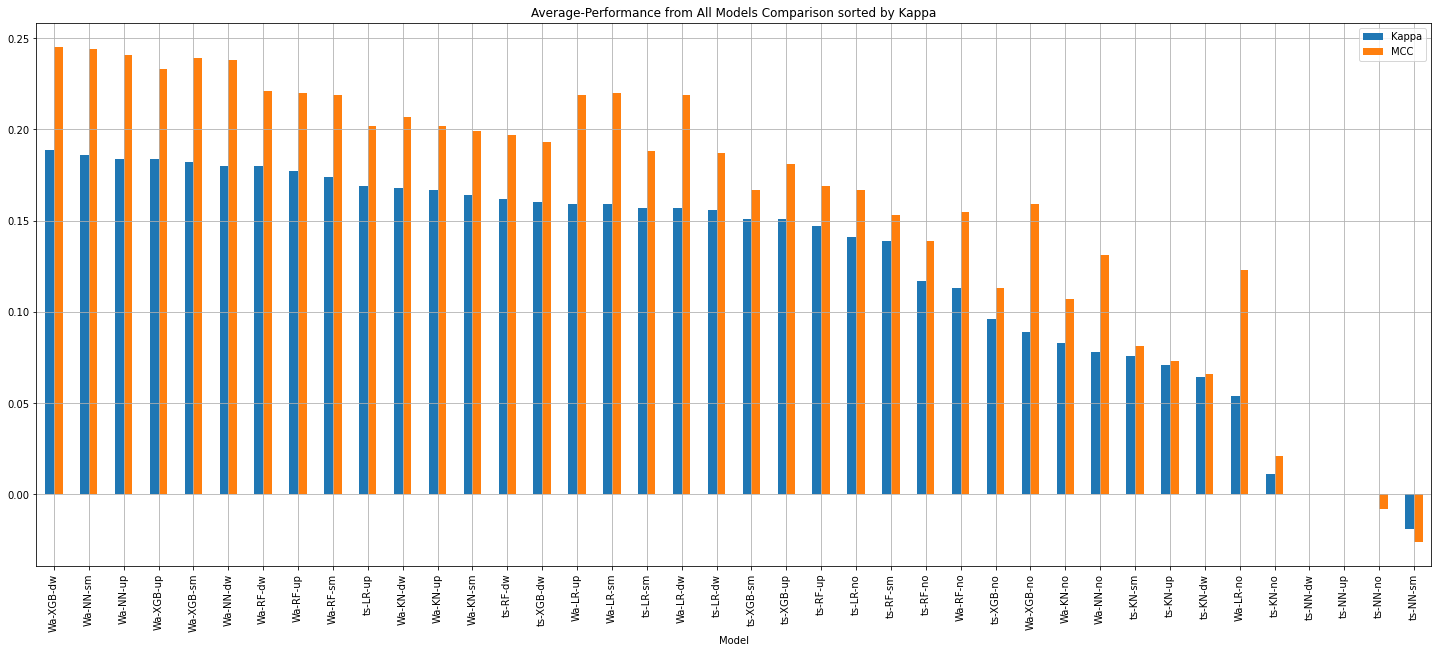

In [ ]:
ax = avg_kappa.plot.bar(
    title='Average-Performance from All Models Comparison sorted by Kappa', 
    grid=True, figsize=(25, 10))


In [ ]:
avg_table = average_df.sort_values(
    by='Kappa', ascending=False).reset_index(drop=True)
avg_table.style.bar(subset=['AUC', 'Kappa', 'MCC', 'Light Acc', 'Deep Acc', 'REM Acc', 'Wake Acc'], 
                    align='mid',
                    color=['#d65f5f', '#5fba7d'])


,Model,AUC,Kappa,MCC,Light Acc,Deep Acc,REM Acc,Wake Acc
0,Wa-XGB-dw,0.751000,0.189000,0.245000,0.043000,0.754000,0.614000,0.785000
1,Wa-NN-sm,0.752000,0.186000,0.244000,0.025000,0.766000,0.607000,0.789000
2,Wa-NN-up,0.749000,0.184000,0.241000,0.029000,0.762000,0.598000,0.801000
3,Wa-XGB-up,0.750000,0.184000,0.233000,0.070000,0.725000,0.596000,0.780000
4,Wa-XGB-sm,0.749000,0.182000,0.239000,0.026000,0.762000,0.587000,0.803000
5,Wa-NN-dw,0.750000,0.180000,0.238000,0.013000,0.755000,0.624000,0.790000
6,Wa-RF-dw,0.731000,0.180000,0.221000,0.113000,0.693000,0.573000,0.727000
7,Wa-RF-up,0.732000,0.177000,0.220000,0.098000,0.736000,0.578000,0.667000
8,Wa-RF-sm,0.729000,0.174000,0.219000,0.080000,0.722000,0.588000,0.690000
9,ts-LR-up,0.721000,0.169000,0.202000,0.236000,0.667000,0.458000,0.608000


In [43]:
avg_AUC = avg_.drop(columns=['Kappa', 'MCC'])
avg_AUC = avg_AUC.sort_values(by='AUC', ascending=False)
avg_AUC


,AUC,Light Acc,Deep Acc,REM Acc,Wake Acc
Model,,,,,
Wa-XGB-no,0.753,0.954,0.087,0.020,0.333
Wa-NN-sm,0.752,0.025,0.766,0.607,0.789
Wa-NN-no,0.752,0.939,0.000,0.077,0.350
Wa-XGB-dw,0.751,0.043,0.754,0.614,0.785
Wa-XGB-up,0.750,0.070,0.725,0.596,0.780
Wa-NN-dw,0.750,0.013,0.755,0.624,0.790
Wa-XGB-sm,0.749,0.026,0.762,0.587,0.803
Wa-NN-up,0.749,0.029,0.762,0.598,0.801
Wa-RF-no,0.737,0.916,0.095,0.104,0.338


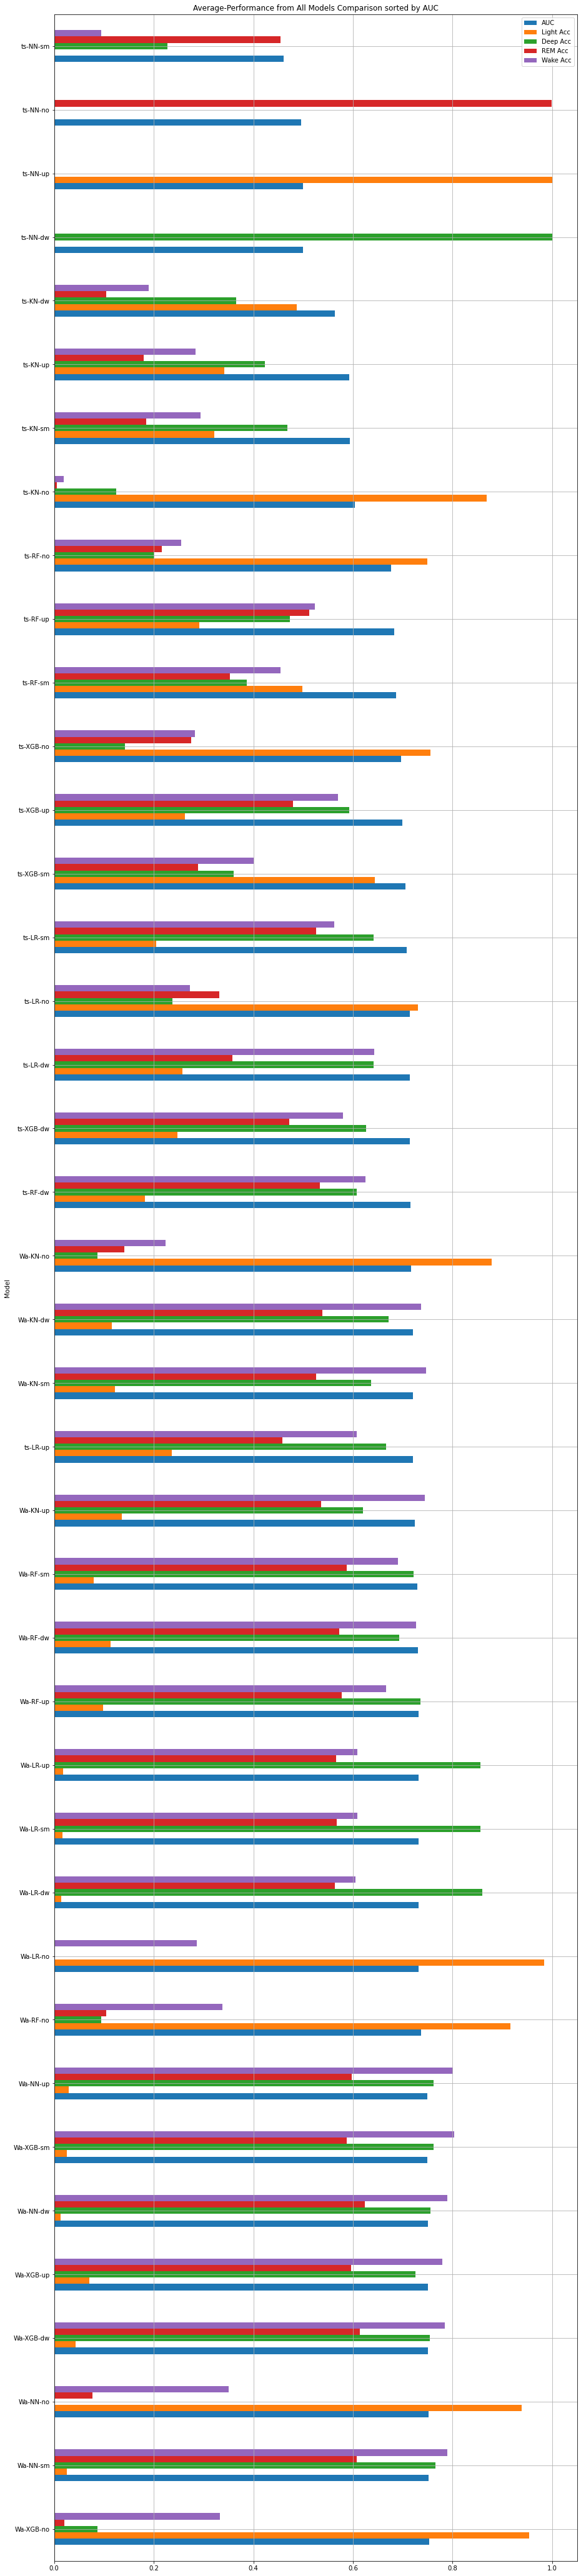

In [44]:
ax = avg_AUC.plot.barh(title='Average-Performance from All Models Comparison sorted by AUC',
                       grid=True, figsize=(15, 75))


In [72]:
def get_columns_list(by='algorithm', value='XGB', metric='AUC'):
    return_columns = []
    features_source = ['ts', 'Wa']
    algorithms  = ['XGB', 'RF', 'LR', 'KN', 'NN']
    resamplings = ['no', 'dw', 'up', 'sm']
    
    if by == 'algorithm':
        for r in resamplings:
            for s in features_source:
                col = '{}-{}-{}_{}'.format(s, value, r, metric)
                return_columns.append(col)
    else:
        for a in algorithms:
            for s in features_source:
                col = '{}-{}-{}_{}'.format(s, a, value, metric)
                return_columns.append(col)
    
    return return_columns
    


#### Performance by resampling techniques

##### No resampling

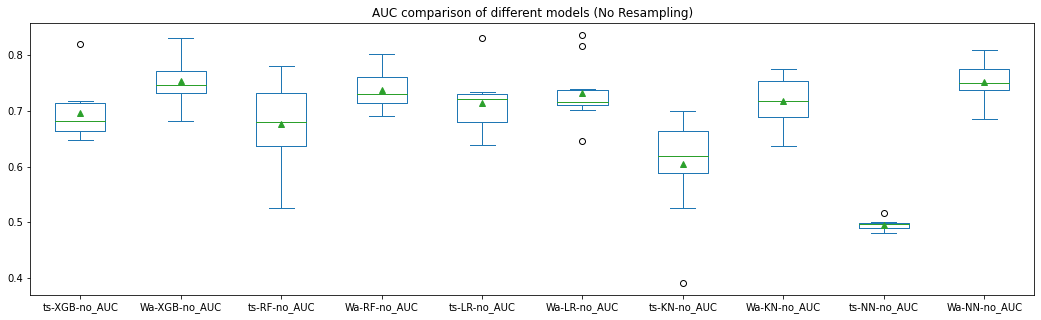

In [73]:
AUC_no_cols = get_columns_list(by='resampling', value='no', metric='AUC')
AUC_no_df   = performance_df[AUC_no_cols]

ax = AUC_no_df.plot.box(title="AUC comparison of different models (No Resampling)",
                        showmeans=True, figsize=(18, 5))


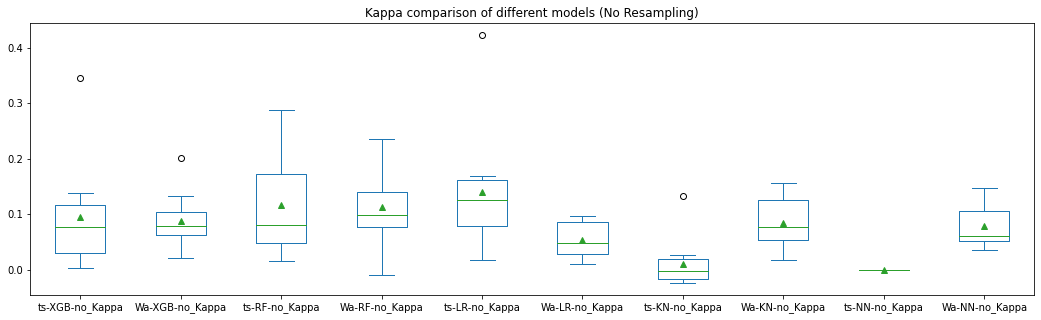

In [74]:
k_no_cols = get_columns_list(by='resampling', value='no', metric='Kappa')
k_no_df   = performance_df[k_no_cols]

ax = k_no_df.plot.box(title="Kappa comparison of different models (No Resampling)",
                      showmeans=True, figsize=(18, 5))


##### Down resampling

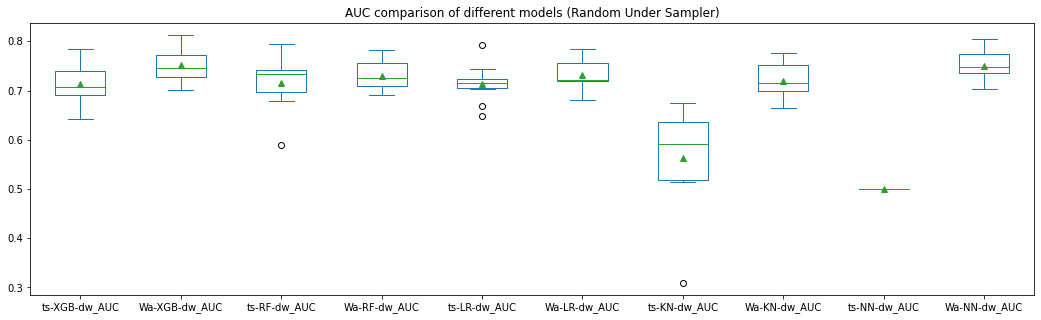

In [75]:
AUC_dw_cols = get_columns_list(by='resampling', value='dw', metric='AUC')
AUC_dw_df   = performance_df[AUC_dw_cols]

ax = AUC_dw_df.plot.box(title="AUC comparison of different models (Random Under Sampler)",
                      showmeans=True, figsize=(18, 5))


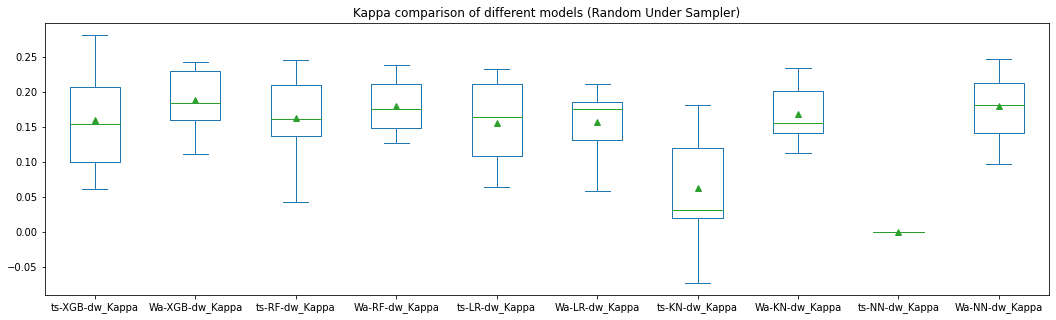

In [76]:
k_dw_cols = get_columns_list(by='resampling', value='dw', metric='Kappa')
k_dw_df   = performance_df[k_dw_cols]

ax = k_dw_df.plot.box(title="Kappa comparison of different models (Random Under Sampler)",
                      showmeans=True, figsize=(18, 5))


##### Up resampling

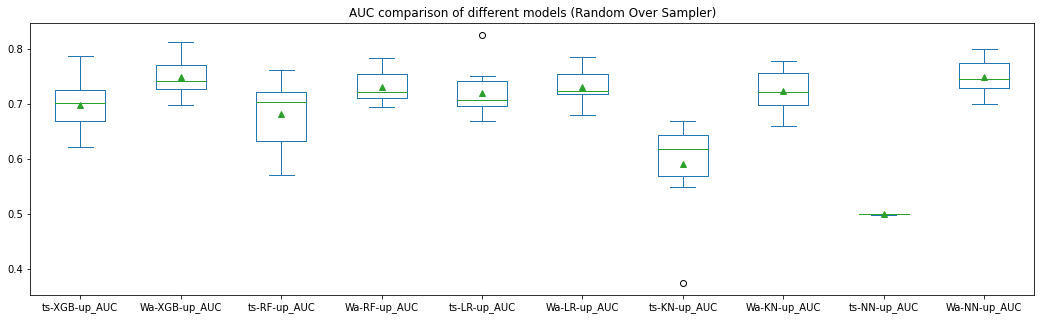

In [77]:
AUC_up_cols = get_columns_list(by='resampling', value='up', metric='AUC')
AUC_up_df   = performance_df[AUC_up_cols]

ax = AUC_up_df.plot.box(title="AUC comparison of different models (Random Over Sampler)",
                      showmeans=True, figsize=(18, 5))


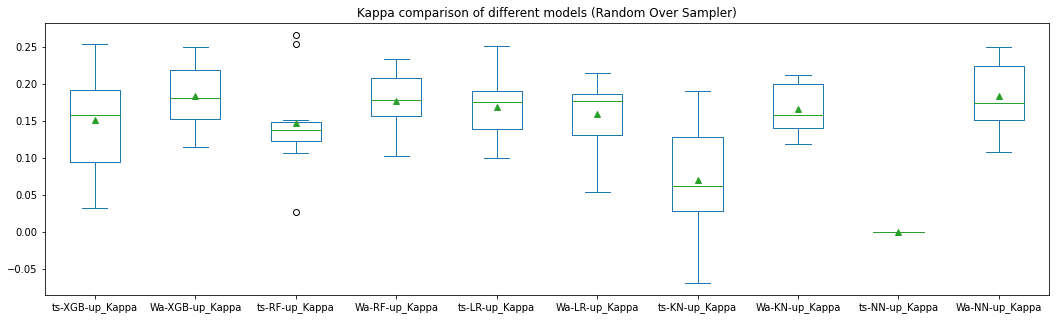

In [78]:
k_up_cols = get_columns_list(by='resampling', value='up', metric='Kappa')
k_up_df   = performance_df[k_up_cols]

ax = k_up_df.plot.box(title="Kappa comparison of different models (Random Over Sampler)",
                      showmeans=True, figsize=(18, 5))


##### Smote resampling

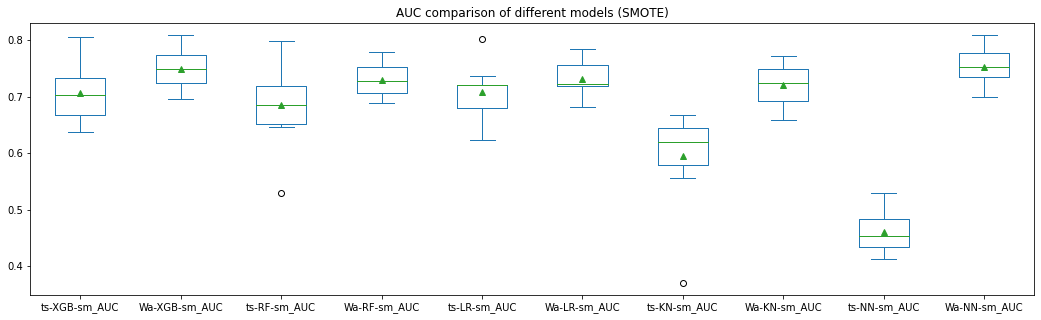

In [79]:
AUC_sm_cols = get_columns_list(by='resampling', value='sm', metric='AUC')
AUC_sm_df   = performance_df[AUC_sm_cols]

ax = AUC_sm_df.plot.box(title="AUC comparison of different models (SMOTE)",
                        showmeans=True, figsize=(18, 5))


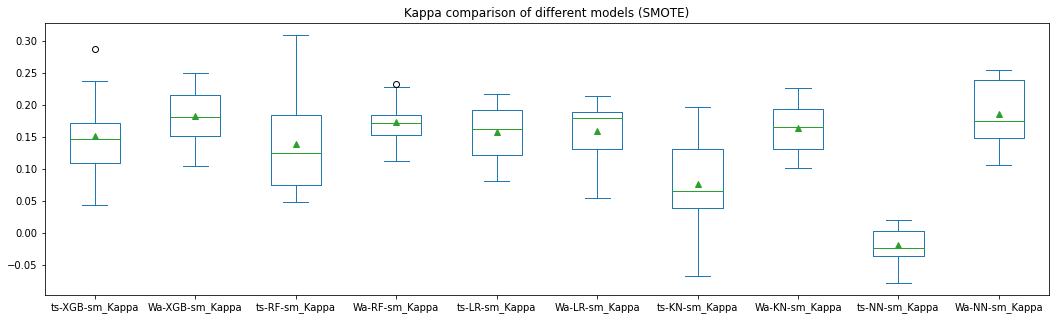

In [80]:
k_sm_cols = get_columns_list(by='resampling', value='sm', metric='Kappa')
k_sm_df   = performance_df[k_sm_cols]

ax = k_sm_df.plot.box(title="Kappa comparison of different models (SMOTE)",
                      showmeans=True, figsize=(18, 5))


#### Performance by ML Algorithms

##### XGB

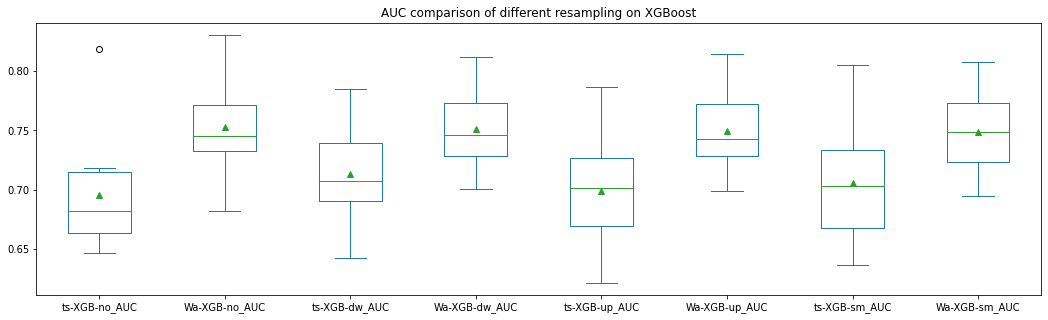

In [81]:
xgb_auc_cols = get_columns_list(by='algorithm', value='XGB', metric='AUC')
xgb_auc_df = performance_df[xgb_auc_cols]

ax = xgb_auc_df.plot.box(title="AUC comparison of different resampling on XGBoost",
                         showmeans=True, figsize=(18, 5))



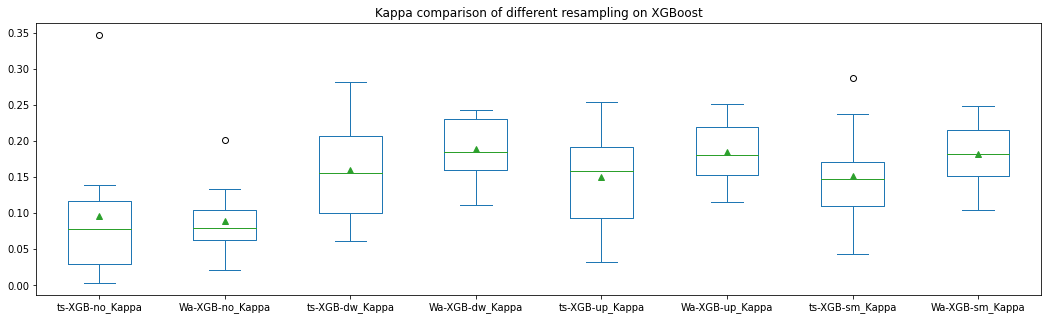

In [82]:
xgb_k_cols = get_columns_list(by='algorithm', value='XGB', metric='Kappa')
xgb_k_df = performance_df[xgb_k_cols]

ax = xgb_k_df.plot.box(title="Kappa comparison of different resampling on XGBoost",
                       showmeans=True, figsize=(18, 5))


##### Neural Network

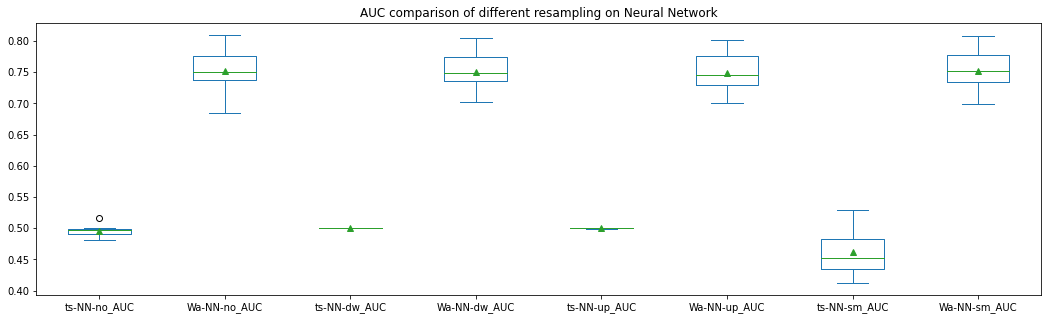

In [83]:
nn_auc_cols = get_columns_list(by='algorithm', value='NN', metric='AUC')
nn_auc_df   = performance_df[nn_auc_cols]

ax = nn_auc_df.plot.box(title="AUC comparison of different resampling on Neural Network",
                         showmeans=True, figsize=(18, 5))


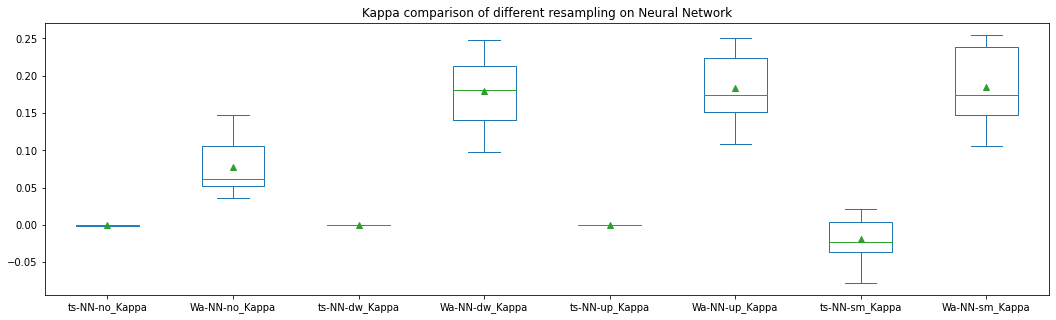

In [84]:
nn_k_cols = get_columns_list(by='algorithm', value='NN', metric='Kappa')
nn_k_df   = performance_df[nn_k_cols]

ax = nn_k_df.plot.box(title="Kappa comparison of different resampling on Neural Network",
                      showmeans=True, figsize=(18, 5))


##### Random Forest

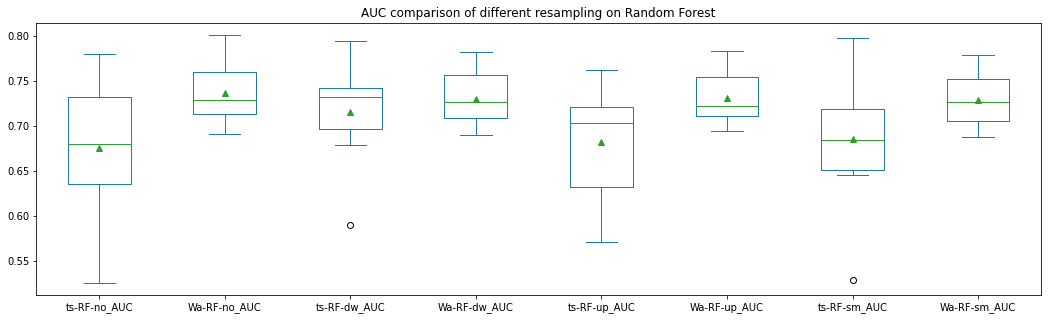

In [85]:
rf_auc_cols = get_columns_list(by='algorithm', value='RF', metric='AUC')
rf_auc_df   = performance_df[rf_auc_cols]

ax = rf_auc_df.plot.box(title="AUC comparison of different resampling on Random Forest",
                         showmeans=True, figsize=(18, 5))


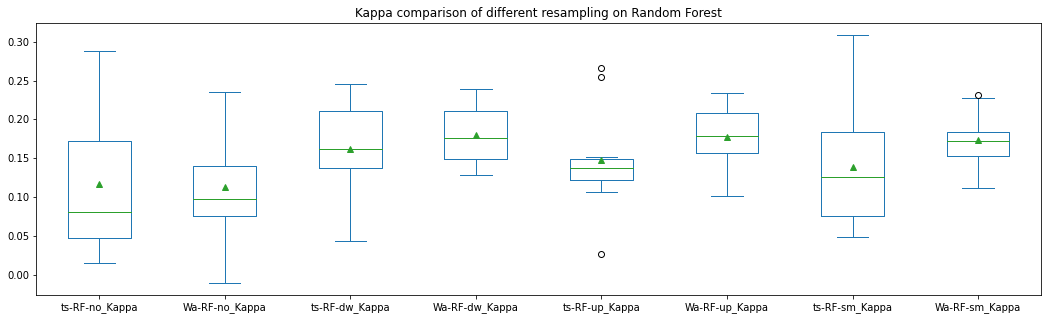

In [86]:
rf_k_cols = get_columns_list(by='algorithm', value='RF', metric='Kappa')
rf_k_df   = performance_df[rf_k_cols]

ax = rf_k_df.plot.box(title="Kappa comparison of different resampling on Random Forest",
                      showmeans=True, figsize=(18, 5))


##### Logistic Regression

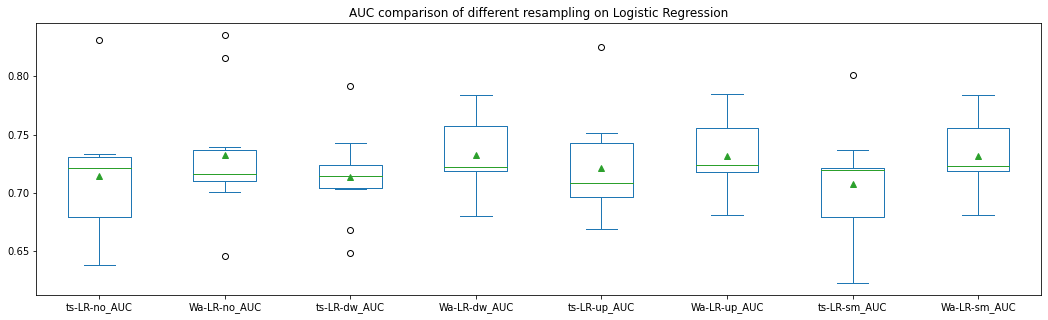

In [87]:
lr_auc_cols = get_columns_list(by='algorithm', value='LR', metric='AUC')
lr_auc_df   = performance_df[lr_auc_cols]

ax = lr_auc_df.plot.box(title="AUC comparison of different resampling on Logistic Regression",
                         showmeans=True, figsize=(18, 5))


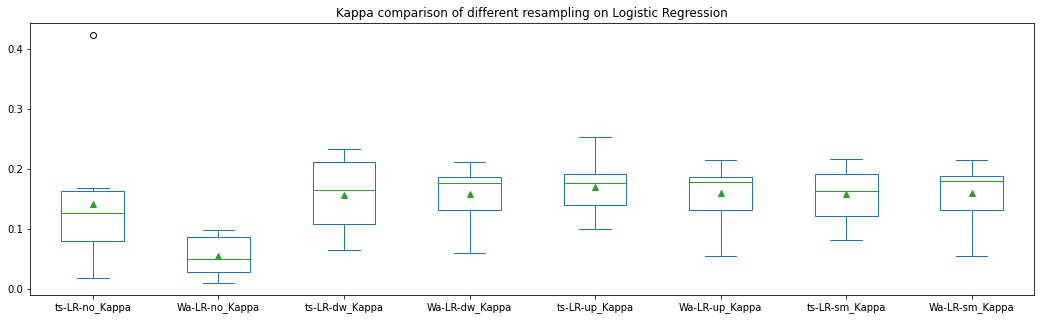

In [88]:
lr_k_cols = get_columns_list(by='algorithm', value='LR', metric='Kappa')
lr_k_df   = performance_df[lr_k_cols]

ax = lr_k_df.plot.box(title="Kappa comparison of different resampling on Logistic Regression",
                      showmeans=True, figsize=(18, 5))


##### K-Nearest Neighbor

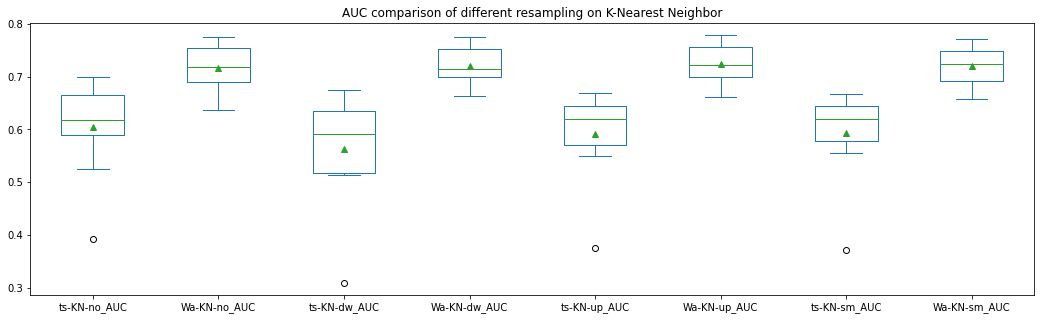

In [89]:
kn_auc_cols = get_columns_list(by='algorithm', value='KN', metric='AUC')
kn_auc_df   = performance_df[kn_auc_cols]

ax = kn_auc_df.plot.box(title="AUC comparison of different resampling on K-Nearest Neighbor",
                         showmeans=True, figsize=(18, 5))


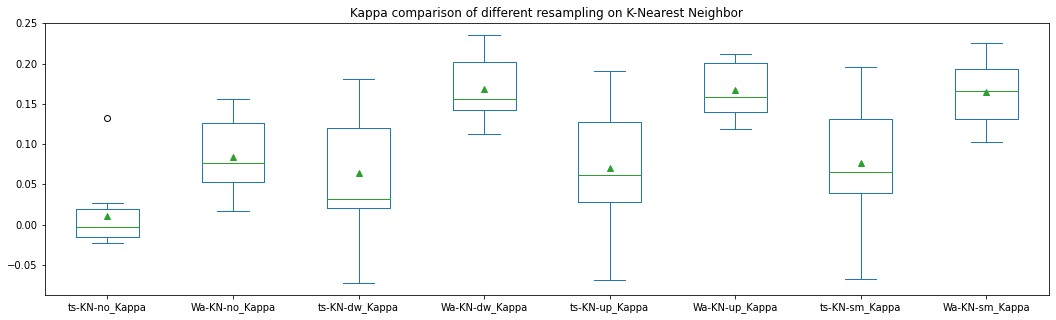

In [90]:
kn_k_cols = get_columns_list(by='algorithm', value='KN', metric='Kappa')
kn_k_df   = performance_df[kn_k_cols]

ax = kn_k_df.plot.box(title="Kappa comparison of different resampling on K-Nearest Neighbor",
                      showmeans=True, figsize=(18, 5))
